# Problem formulation

The problem that we are researching for the purpose of this class is predicting rainfall in Białystok based on historical data collected since 1951 up to 2021.

Information obtained as a result of our research can be a valuable information for farmers in Białystok neighbourhood interesed in predicting rainfall, as it is key for crops to grow. The month of June is typically when they plant seeds and with information obtained from our project they will be able to decide what kind of crops to grow that year based on predicted rainfall.

Data used for the purpose of this assignment comes from following website:
https://meteomodel.pl/dane/srednie-miesieczne/?imgwid=353230295&par=prcp&max_empty=2

It contains numerical values of different atmospheric phenomenas collected monthly over the course of certain time period given in years.

In this project we used rainfall and humidity data collected over 70 years for the month of June. Rainfall values were given in milimeters (mm) and humidity values in percents (%).

In order to be able to use rainfall and humidity data in our models we downloaded it from the website and exported it to  .xlsx files named 'opady.xlsx' and 'wilgotnosc.xlsx' accordingly. Data was comprehensive (no Null values etc.) and didn't require any preprocessing.

In [748]:
import pandas as pd
from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt
import numpy as np
import arviz as az

In [749]:
data = pd.DataFrame(pd.read_excel('opady.xlsx',index_col=0)[:71][:])
data.head()

,I,II,III,IV,V,VI,VII,VIII,IX,X,XI,XII,I-XII
Rok,,,,,,,,,,,,,
1951,29.4,27.2,59.1,23.5,62,88.9,68.2,16.6,12.9,1.9,28.6,18.1,436.4
1952,25,37.9,16.5,32.6,62.8,112.5,12.6,75.4,139.8,112.5,83.3,25.2,736.1
1953,33.6,51.5,3.7,14,37.9,51.8,48.9,44.2,37.8,1.4,21.3,18.8,364.9
1954,22,15.3,17.2,54.8,52.4,39.9,104.9,52.1,17.1,31.4,28.6,85.9,521.6
1955,25.1,36.2,25.7,54.7,55.3,53.1,98.1,12.7,20.7,31.3,29.3,88.6,530.8


In [750]:
print(data["VI"])

Rok
1951     88.9
1952    112.5
1953     51.8
1954     39.9
1955     53.1
        ...  
2017    116.1
2018     22.4
2019     50.3
2020    138.6
2021     49.3
Name: VI, Length: 71, dtype: object


In [751]:
year = data.index.to_numpy()
data_june = np.array(data.iloc[:,5])

In [752]:
std_june= int(np.std(data_june))
avg_june = int(np.mean(data_june))

print("Standard deviation June:", std_june)
print("Expectation June:", avg_june)

print(f"Max rainfall value {max(data_june)} [mm]")
print(f"Min rainfall value {min(data_june)}[mm]")

Standard deviation June: 34
Expectation June: 68
Max rainfall value 227.1 [mm]
Min rainfall value 18[mm]


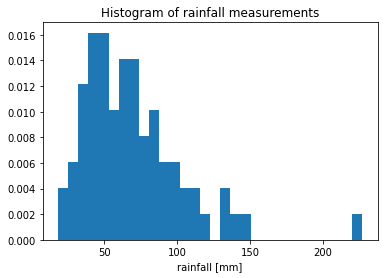

In [753]:
plt.hist(data_june, bins = 30, density=True)
plt.title("Histogram of rainfall measurements")
plt.xlabel('rainfall [mm]')
plt.show()

From the histogram above we can see that there is one abnormally high measurement and then a cluster of measurements that we approximate to be somewhat symmetrically distributed.

# Models

### Model 1:
Our first approach will be to apply a Student-t likelihood.

Student's t-distribution, is a type of probability distribution that is similar to the normal distribution with its bell shape but has heavier tails. T distributions have a greater chance for extreme values than normal distributions, hence the fatter tails.

Student-t model is characterized by three parameters:
$v$ - degrees of freedom
$\mu$ - location
$\sigma$ - scale

Priors for location and scale are similar to the ones for mean and standard deviation in case of normal distribution. We chose $mu$ parameter to be normally distributed, and $sigma$ to be a fixed parameter - exponential.

Degrees of freedom control the thickness of distribution tails, providing robustness to outliers.
Degrees of freedom are in our case a gamma distribution. This prior and it's parameters were recommended as a default option for student_t's degrees of freedom parameter in the article found online. [https://statmodeling.stat.columbia.edu/2015/05/17/do-we-have-any-recommendations-for-priors-for-student_ts-degrees-of-freedom-parameter/]

In this model we will only use rainfall data.


### Prior predicitve checks

In [754]:
model_Firstprim = CmdStanModel(stan_file='model_studentT.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [755]:
with open('model_studentT.stan') as file:
    print(file.read())
    file.close()

data{
    int mean;
    int variance;
}
generated quantities{
    real mu = normal_rng(mean, variance);
    real sigma = exponential_rng(0.067);
    real nu = gamma_rng(2, 0.1);
    real rainfall = student_t_rng(nu, mu, sigma);
}


In [756]:
R = 1000
data_StudentModel = dict(
            mean = int(avg_june-10),
            variance = int(std_june/1.5)
            )
fit_StudentModel = model_Firstprim.sample(data = data_StudentModel,
                    iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [757]:
sim_student = fit_StudentModel.stan_variable('rainfall')
mu_student = fit_StudentModel.stan_variable('mu')
sigma_student = fit_StudentModel.stan_variable('sigma')
nu_student = fit_StudentModel.stan_variable('nu')

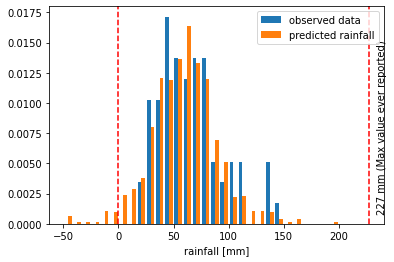

In [758]:
plt.hist([data_june,sim_student], range = [-50, 200],bins = 30, density=True)
plt.legend(['observed data','predicted rainfall'])
plt.annotate(text='227 mm (Max value ever reported)',xy=(235,0.001), rotation = 90, )
plt.axvline(x=np.max(data_june), color = 'r', linestyle = '--')
plt.axvline(x=0, color = 'r', linestyle = '--')
plt.xlabel('rainfall [mm]')
plt.show()

Proposed model fits the data quite well. There are some negative values that don't make much sense from a physical standpoint, but majority is greater than zero and it doesn't exceed maximum rainfall ever noted in Białystok.

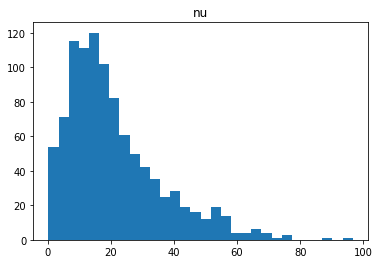

In [759]:
plt.hist(nu_student, bins =30)
plt.title('nu')
plt.show()

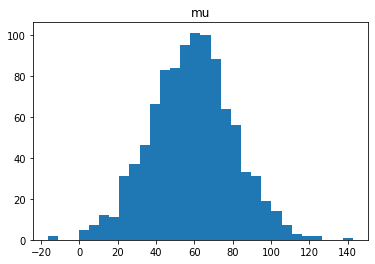

In [760]:
plt.hist(mu_student, bins=30)
plt.title('mu')
plt.show()

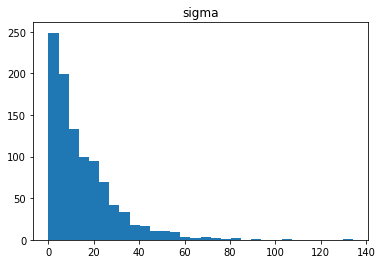

In [761]:
plt.hist(sigma_student, bins=30)
plt.title('sigma')
plt.show()

## Posterior predicive check

In [762]:
model_student_post = CmdStanModel(stan_file='model_studentT_posterior.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [763]:
with open('model_studentT_posterior.stan') as file:
    print(file.read())
    file.close()

data{
    int N;
    real rainfalls[N];
    int mean;
    int variance;
}

parameters{
    real mu;
    real<lower=0> sigma;
    real<lower=0> nu;
}

model{
    mu~ normal(mean, variance);
    nu ~ gamma(2, 0.1);
    sigma ~ exponential(0.067);
    rainfalls ~ student_t(nu, mu, sigma);
}
generated quantities{
    real rainfall[N];
    vector[N] log_lik;
    for (i in 1:N){
        rainfall[i] = student_t_rng(nu, mu, sigma);
        log_lik[i] = student_t_lpdf(rainfalls[i] | nu, mu, sigma);
    }

}




In [764]:
data_Student_post = dict(
            N = len(data_june),
            rainfalls = list(data_june),
            mean = int(avg_june-10),
            variance = int(std_june/1.5))
fit_Student_post = model_student_post.sample(data = data_Student_post, seed=28062022)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status
chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 2 |▍         | 00:00 Status

chain 3 |▍         | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)
chain 2 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 3 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 4 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 3 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [765]:
fit_Student_post.diagnose()

'Processing csv files: /tmp/tmpb10ekwrf/model_studentT_posterior-20220619171229_1.csv, /tmp/tmpb10ekwrf/model_studentT_posterior-20220619171229_2.csv, /tmp/tmpb10ekwrf/model_studentT_posterior-20220619171229_3.csv, /tmp/tmpb10ekwrf/model_studentT_posterior-20220619171229_4.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.\n'

No issues with sampling

In [766]:
sim_studentP = fit_Student_post.stan_variable('rainfall')
mu_studentP = fit_Student_post.stan_variable('mu')
sigma_studentP = fit_Student_post.stan_variable('sigma')
nu_studentP = fit_Student_post.stan_variable('nu')

In [767]:
az.summary(fit_Student_post, var_names=['mu', 'sigma', 'nu'], round_to=2, kind='stats')

,mean,sd,hdi_3%,hdi_97%
mu,64.34,3.85,56.83,71.47
sigma,27.13,3.75,19.76,33.81
nu,8.37,6.22,1.79,19.23


In [768]:
fitStudent_id = az.from_cmdstanpy(posterior=fit_Student_post,
                           log_likelihood='log_lik',
                           posterior_predictive='rainfall',
                           observed_data={'rainfalls':data_june})
fitStudent_id

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

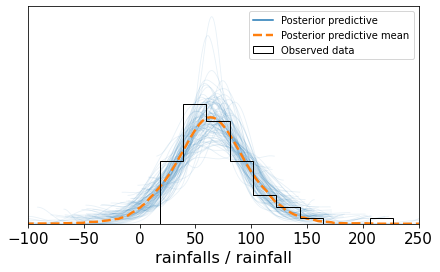

In [769]:
ax=az.plot_ppc(data = fitStudent_id, alpha=0.1,figsize=(7, 4),data_pairs={'rainfalls':'rainfall'},num_pp_samples=100, observed=False)
ax.set_xlim((-100,250))
ax.hist(data_june,histtype='step',edgecolor='black',density=True,label='Observed data')
ax.legend()
plt.show()

From the plot generated above we can see proposed model fits observed data well. Since our data is sligtly asymetrical, left side of distribution is not fitting it perfectly. Other than that the model is capturing the diffusion of our data. Heavier tails provided by Student-t distribution allowed us to better capture abnormally high values. Posterior predicitive mean is approximating the bulk of data rather well.

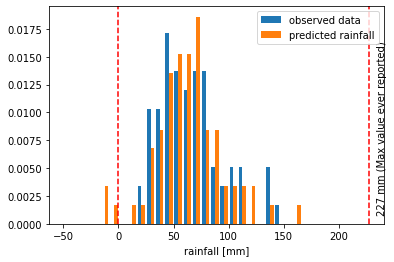

In [770]:
plt.hist([data_june, sim_studentP[0]], range = [-50, 200],bins = 30, density=True)
plt.legend(['observed data','predicted rainfall'])
plt.annotate(text='227 mm (Max value ever reported)',xy=(235,0.001), rotation = 90, )
plt.axvline(x=np.max(data_june), color = 'r', linestyle = '--')
plt.axvline(x=0, color = 'r', linestyle = '--')
plt.xlabel('rainfall [mm]')
plt.show()

Proposed model proves to be adequate for our problem.

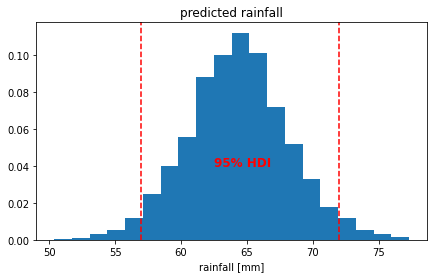

Mean: 64.34
95% confidence interval:  ['57.25', '72.61']


In [771]:
mu_95student = az.hdi(mu_studentP,.95)
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.hist(mu_studentP,bins=20,density=True)
plt.axvline(int(mu_95student[0]), linestyle = '--', color = 'r')
plt.axvline(int(mu_95student[1]), linestyle = '--', color = 'r')
plt.text(62.5, 0.04, '95% HDI', fontsize = 12, weight = 'bold', color = 'r')
plt.title('predicted rainfall')
plt.xlabel('rainfall [mm]')
plt.show()
print('Mean: {:4.2f}'.format(np.mean(mu_studentP)))
print('95% confidence interval: ',['{:4.2f}'.format(k) for k in az.hdi(mu_studentP,.95)])

Looking at results we can see that the is 95 % probability that rainfall will be between 56 and 72 mm. Based on historical data and common sense received values are reasonable.

### Model 2:

Our second approach will be to apply a Gaussian model. We will try to fit normal distribution to our rainfall data.

For our second model we also decided to add additional parameter : humidity, since it's closely related to rainfall. When it rains, it will increase the relative humidity because of the evaporation. The air where the rain is falling may not be completely saturated with water vapor. However, the longer it rains, the more the humidity will increase because of the air constantly drawing the water.

  The simplest model of the rainfall - humidity relation is linear and that's what we will use for our model.

For this model we will use both rainfall and humidity data.

Standard Bayesian model:
$outcome_{i}$ ~ Normal($\mu_{i}$, $\sigma$)
$\mu_{i}$ = $\alpha$+ $\beta$ * $predictor_{i}$
$\alpha$ ~ Normal(a,b)
$\beta$ ~ Normal(c,d)
$\sigma$ ~ Exponential(0.067)

We created new list with humidity data and center our variables (substract humidity values by their mean) to make it easier to interpret.

In [772]:
data_humidity = pd.DataFrame(pd.read_excel('wilgotnosc.xlsx',index_col=0)[:71][:])
data_humidity.head()

,I,II,III,IV,V,VI,VII,VIII,IX,X,XI,XII,I-XII
Rok,,,,,,,,,,,,,
1951,86.9,86.5,82.5,72.1,75.6,71.1,75.3,72.1,78.1,82.4,87.9,88.2,79.9
1952,86.7,88.4,76.5,76.0,75.5,74.6,74.4,79.5,84.1,90.6,92.6,92.8,82.6
1953,91.6,87.6,76.6,68.2,66.1,74.0,75.8,77.9,83.4,79.1,82.2,90.7,79.4
1954,86.9,84.7,84.9,78.1,76.0,73.8,82.8,83.2,79.6,83.7,86.9,90.7,82.6
1955,87.4,87.7,83.4,78.4,75.4,74.7,77.8,75.4,83.1,86.4,90.1,89.9,82.5


In [773]:
data_humidity = np.array(data_humidity.iloc[:,5])

In [774]:
humidity_values = [i-np.mean(data_humidity) for i in data_humidity]

### Prior predicitve checks

In [775]:
model_humidity = CmdStanModel(stan_file="model_with_humidity.stan")

INFO:cmdstanpy:found newer exe file, not recompiling


In [776]:
with open('model_with_humidity.stan') as file:
    print(file.read())
    file.close()

data{
    int N;
    real humidity[N];
}

generated quantities{
    real alpha = normal_rng(70,36);
    real beta = normal_rng(0, 36);
    real sigma = exponential_rng(0.067);
    real rainfall[N];
    for (i in 1:N){
        rainfall[i] = normal_rng(humidity[i]*beta+alpha, sigma);
    }
}


Our alpha parameter is a normal distribution since it's a typical choice for Bayesian linear models. We feed it mean and variance of rainfall data.
Beta parameter in this case is also a normal distribution.
Sigma parameter is an exponential_rng with value 0.067. That gives us variance of around 15 mm (1/0.067) for our rainfall.

In [777]:
R = 1000
data_sim_pres = {"N": len(humidity_values), "humidity":np.linspace(np.min(humidity_values),np.max(humidity_values), len(humidity_values))}

sim_humidity = model_humidity.sample(data = data_sim_pres,
                     iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


In [778]:
beta_humid = sim_humidity.stan_variable('beta')
alpha_humid = sim_humidity.stan_variable('alpha')

Text(80, 20, 'min')

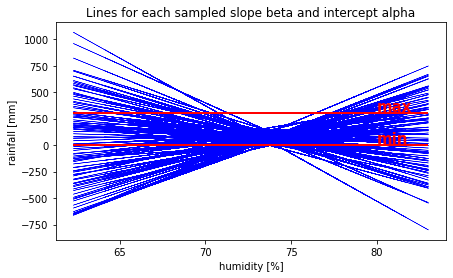

In [779]:
fig, axes = plt.subplots(1,1,figsize=(7,4))

for i in range(100):
    axes.plot(data_humidity, alpha_humid[i]+beta_humid[i]*np.array(humidity_values), linewidth = 0.5, color='b')
plt.title("Lines for each sampled slope beta and intercept alpha")
axes.set_xlabel('humidity [%]')
axes.set_ylabel('rainfall [mm]')
axes.hlines([0, 300],xmin = data_humidity.min(), xmax = data_humidity.max(), linestyles = '-',linewidth = 2, color = 'r')
axes.annotate(text='max',xy=(80,320), weight = 'bold', color = 'r', fontsize = 15)
axes.annotate(text='min',xy=(80,20), weight = 'bold', color = 'r', fontsize = 15)

Proposed model is not ideal. It gives us too small and too big values. We also get negative values that don't make much sense. This prior for Beta is not good: it gives us negative slopes and that is not a good thing in this case (in theory the higher the humidity the more rainfall we get). Chosen prior for beta leads to nonsense values so we will modify this prior.

### Prior modification
We change our Beta parameter distribution from normal_rng to lognormal_rng. Lognormal is a positive continuous distribution and in our case study it makes sense that the values should be positive.

In [780]:
model_SecondBeta = CmdStanModel(stan_file="model_with_humidity_betaLog.stan")

INFO:cmdstanpy:found newer exe file, not recompiling


In [781]:
with open('model_with_humidity_betaLog.stan') as file:
    print(file.read())
    file.close()

data{
    int N;
    real humidity[N];
}

generated quantities{
    real alpha = normal_rng(70,36);
    real beta = lognormal_rng(0, 1);
    real sigma = exponential_rng(0.067);
    real rainfall[N];
    for (i in 1:N){
        rainfall[i] = normal_rng(humidity[i]*beta+alpha, sigma);
    }
}


In [782]:
R = 1000
data_sim_hum = {"N": len(humidity_values), "humidity":np.linspace(np.min(humidity_values),np.max(humidity_values), len(humidity_values))}
sim_hum_Beta = model_SecondBeta.sample(data = data_sim_hum,
                    iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


In [783]:
beta_SecondLog = sim_hum_Beta.stan_variable('beta')
alpha_SecondLog = sim_hum_Beta.stan_variable('alpha')
rain_SecondLog = sim_hum_Beta.stan_variable('rainfall')

Text(80, 10, 'min')

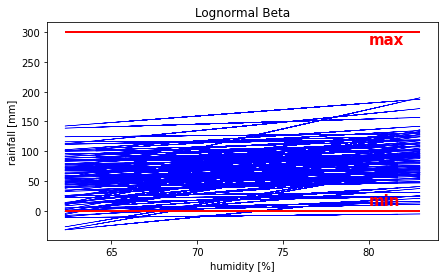

In [784]:
fig, axes = plt.subplots(1,1,figsize=(7,4))

for i in range(100):
    axes.plot(data_humidity, alpha_SecondLog[i]+beta_SecondLog[i]*np.array(humidity_values), linewidth = 0.5, color='b')
plt.title("Lognormal Beta")
axes.set_xlabel('humidity [%]')
axes.set_ylabel('rainfall [mm]')
axes.hlines([0, 300],xmin = data_humidity.min(), xmax = data_humidity.max(), linestyles = '-',linewidth = 2, color = 'r')
axes.annotate(text='max',xy=(80,280), weight = 'bold', color = 'r', fontsize = 15)
axes.annotate(text='min',xy=(80,10), weight = 'bold', color = 'r', fontsize = 15)

This model fits much better. Results that we get fit between zero and maximum result recorded. Lognormal prior for beta limits rates to positive slopes. This prior is certainly better for our application. We still get some values below zero but it should no longer be an issue once we feed data to our model.

In [785]:
# This code for ribbon_plot is taken from open source repository of Professor Baranowski
light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
light_grey="#DDDDDD"

def ribbon_plot(xt, fs, ax=None,zorder=0):
    if ax is None:
        ax = plt.gca()
    probs = [10, 20, 30, 40, 50, 60, 70, 80, 90]
    perc_interv=np.percentile(fs, probs, axis=0)
    ax.fill_between(xt,perc_interv[0,:],perc_interv[8,:],color=light,zorder=zorder)
    ax.fill_between(xt,perc_interv[1,:],perc_interv[7,:],color=light_highlight,zorder=zorder)
    ax.fill_between(xt,perc_interv[2,:],perc_interv[6,:],color=mid,zorder=zorder)
    ax.fill_between(xt,perc_interv[3,:],perc_interv[5,:],color=mid_highlight,zorder=zorder)
    ax.plot(xt,perc_interv[4,:],color=dark,zorder=zorder)
    return(ax)

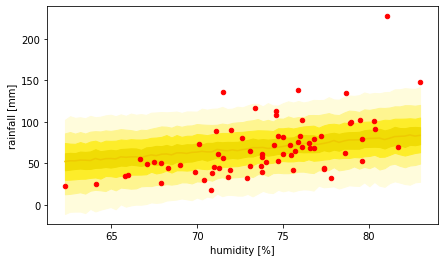

In [786]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes=ribbon_plot(data_sim_hum['humidity']+np.mean(data_humidity),rain_SecondLog,axes)
axes.scatter(data_humidity,data_june,color='red',alpha=1,s=20)
axes.set_xlabel('humidity [%]')
axes.set_ylabel('rainfall [mm]')
plt.show()

Generally chosen priors fit quite well. Good thing that we observe is that most of our data is located in the middle which is a good thing.

### Posterior predictive check

In [787]:
model_post = CmdStanModel(stan_file='model_posterior.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [788]:
with open('model_posterior.stan') as file:
    print(file.read())
    file.close()

data{
    int N;
    vector [N] humidity;
    real rainfalls[N];
}

parameters{
    real alpha;
    real beta;
    real<lower=0> sigma;
}

transformed parameters{
    vector[N] mu = humidity*beta+alpha;
}

model{
    alpha~ normal(70,36);
    beta ~ lognormal(0,1);
    sigma ~ exponential (0.067);
    rainfalls ~ normal(mu, sigma);
}

generated quantities{
    vector[N] log_lik;
    real rainfall[N];
    for (i in 1:N){
        rainfall[i] = normal_rng(mu[i], sigma);
        log_lik[i] = normal_lpdf(rainfalls[i] | mu[i], sigma);
    }
}


In [789]:
data_post = dict(N = len(humidity_values),
                 humidity = humidity_values,
                 rainfalls = list(data_june))
fit_post = model_post.sample(data=data_post, seed = 20062022)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status
chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status


chain 1 |▍         | 00:00 Status
chain 2 |▍         | 00:00 Status


chain 4 |▍         | 00:00 Status

chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 2 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 4 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 3 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 2 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)

chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)


chain 4 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed          


INFO:cmdstanpy:CmdStan done processing.


In [790]:
fit_post.diagnose()

'Processing csv files: /tmp/tmpb10ekwrf/model_posterior-20220619171234_1.csv, /tmp/tmpb10ekwrf/model_posterior-20220619171234_2.csv, /tmp/tmpb10ekwrf/model_posterior-20220619171234_3.csv, /tmp/tmpb10ekwrf/model_posterior-20220619171234_4.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.\n'

No issues with sampling

In [791]:
alpha_post = fit_post.stan_variable('alpha')
beta_post = fit_post.stan_variable('beta')
mu_post = fit_post.stan_variable('mu')
rainfall_pred_post = fit_post.stan_variable('rainfall')

In [792]:
az.summary(fit_post, var_names=['alpha', 'beta', 'sigma'], round_to=2, kind='stats')

,mean,sd,hdi_3%,hdi_97%
alpha,68.77,3.47,61.69,74.89
beta,4.11,0.83,2.57,5.67
sigma,29.35,2.54,24.96,34.21


Parameter alpha informs us that average rainfall is equal to about 69 mm with variance of +- 4 mm.
Beta parameter is our linear function coefficient and it's equal to around 4.

Text(0, 0.5, 'rainfall [mm]')

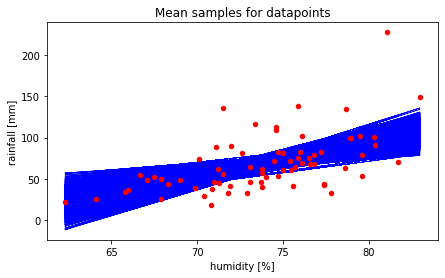

In [793]:
fig, axes = plt.subplots(1,1,figsize=(7,4))

for i in range(len(beta_post)):
        axes.plot(data_humidity, alpha_post[i]+beta_post[i]*np.array(humidity_values), linewidth = 0.5, color='b',zorder=1)
plt.scatter(data_humidity, data_june,color='red',alpha=1,s=20,zorder=2)
plt.title("Mean samples for datapoints")
axes.set_xlabel('humidity [%]')
axes.set_ylabel('rainfall [mm]')

We can see it's located in the middle of our data.

Text(0, 0.5, 'rainfall [mm]')

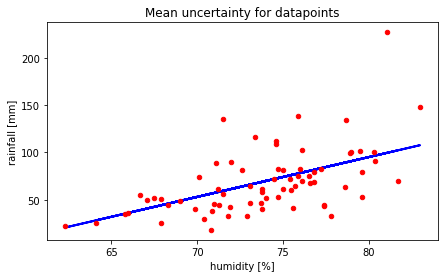

In [794]:
fig, axes = plt.subplots(1,1,figsize=(7,4))
plt.plot(data_humidity, mu_post[0], linewidth = 2, color='b',zorder=1)
plt.scatter(data_humidity, data_june,color='red',alpha=1,s=20,zorder=2)
plt.title("Mean uncertainty for datapoints")
axes.set_xlabel('humidity [%]')
axes.set_ylabel('rainfall [mm]')

The blue line is the distribution of the pressure on the mean of rainfall distribution. This is not an actual prediction but parameter of the distribution.

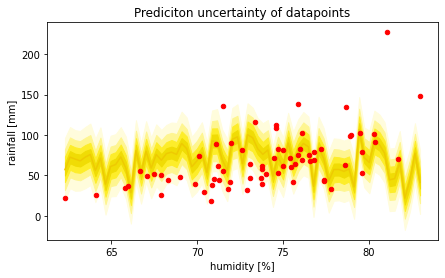

In [795]:
fig, axes = plt.subplots(1,1,figsize=(7,4))

axes = ribbon_plot(data_sim_hum['humidity']+np.mean(data_humidity),rainfall_pred_post,axes)
axes.scatter(data_humidity, data_june,color='red',alpha=1,s=20)
axes.set_title("Prediciton uncertainty of datapoints")
axes.set_xlabel('humidity [%]')
axes.set_ylabel('rainfall [mm]')
plt.show()

We can see that we have a somewhat good coverage of our actual datapoints. Not all of them are covered in this interval but only minority is outside. Our ribbon plot takes shape similar to a polynomial function which makes sense given that our data isn't really condensed.

In [796]:
fit_id = az.from_cmdstanpy(posterior=fit_post,
                           posterior_predictive='rainfall',
                           log_likelihood='log_lik',
                           observed_data={'rainfalls':data_june} )
fit_id

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

### Marginal for selected humidity

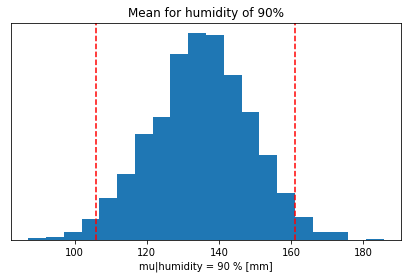

Mean: 135.01
95% confidence interval:  ['106.80', '161.43']


In [797]:
mu90 = alpha_post+beta_post*(90-np.mean(data_humidity))
mu_95p = az.hdi(mu90,.95)
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.hist(mu90,bins=20,density=True)
plt.axvline(int(mu_95p[0]), linestyle = '--', color = 'r')
plt.axvline(int(mu_95p[1]), linestyle = '--', color = 'r')
ax.set_title('Mean for humidity of 90%')
ax.set_yticks(())
ax.set_xlabel('mu|humidity = 90 % [mm]')
plt.show()
print('Mean: {:4.2f}'.format(np.mean(mu90)))
print('95% confidence interval: ',['{:4.2f}'.format(k) for k in az.hdi(mu90,.95)])

Looking at parameter marginal distribution for humidity set to 90% we can see that the is 95 % probability that rainfall will be between 106 and 161 mm. Based on historical data and common sense received values are reasonable.

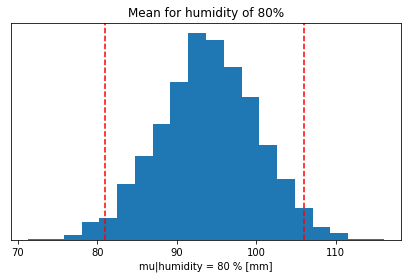

Mean: 93.95
95% confidence interval:  ['81.74', '106.18']


In [798]:
mu80 = alpha_post+beta_post*(80-np.mean(data_humidity))
mu_80p = az.hdi(mu80,.95)
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.hist(mu80,bins=20,density=True)
plt.axvline(int(mu_80p[0]), linestyle = '--', color = 'r')
plt.axvline(int(mu_80p[1]), linestyle = '--', color = 'r')
ax.set_title('Mean for humidity of 80%')
ax.set_yticks(())
ax.set_xlabel('mu|humidity = 80 % [mm]')
plt.show()
print('Mean: {:4.2f}'.format(np.mean(mu80)))
print('95% confidence interval: ',['{:4.2f}'.format(k) for k in az.hdi(mu80,.95)])

Looking at parameter marginal distribution for humidity set to 80% we can see that the is 95 % probability that rainfall will be between 82 and 106 mm. Based on historical data and common sense received values are reasonable.

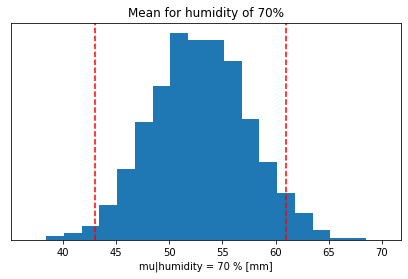

Mean: 52.90
95% confidence interval:  ['43.67', '61.63']


In [799]:
mu70 = alpha_post+beta_post*(70-np.mean(data_humidity))
mu_70p = az.hdi(mu70,.95)
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.hist(mu70,bins=20,density=True)
plt.axvline(int(mu_70p[0]), linestyle = '--', color = 'r')
plt.axvline(int(mu_70p[1]), linestyle = '--', color = 'r')
ax.set_title('Mean for humidity of 70%')
ax.set_yticks(())
ax.set_xlabel('mu|humidity = 70 % [mm]')
plt.show()
print('Mean: {:4.2f}'.format(np.mean(mu70)))
print('95% confidence interval: ',['{:4.2f}'.format(k) for k in az.hdi(mu70,.95)])

Looking at parameter marginal distribution for humidity set to 70% we can see that the is 95 % probability that rainfall will be between 44 and 62 mm. Based on historical data and common sense received values are reasonable.

Moreover, comparing results from all three histograms we see that the higher the predicted rain values are, the higher the humidity. Obtained results are true to nature's laws.

## Model comparison

Posterior summary statistics

In [800]:
print("Summary for Student model:")
fit_Student_post.summary()

Summary for Student model:


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-300.0,0.0310,1.30,-310.0,-300.0,-300.0,1700.0,1800.0,1.0
mu,64.0,0.0830,3.90,58.0,64.0,71.0,2200.0,2300.0,1.0
sigma,27.0,0.0820,3.70,21.0,27.0,34.0,2100.0,2200.0,1.0
nu,8.4,0.1400,6.20,2.9,6.6,20.0,2000.0,2100.0,1.0
rainfall[1],65.0,0.5900,37.00,12.0,65.0,119.0,4008.0,4273.0,1.0
...,...,...,...,...,...,...,...,...,...
log_lik[67],-6.0,0.0071,0.31,-6.5,-5.9,-5.4,1971.0,2101.0,1.0
log_lik[68],-5.5,0.0037,0.20,-5.8,-5.4,-5.2,2853.0,3042.0,1.0
log_lik[69],-4.4,0.0028,0.13,-4.6,-4.4,-4.2,2047.0,2183.0,1.0


In [801]:
print("Summary for Gaussian model:")
fit_post.summary()

Summary for Gaussian model:


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-280.0,0.029,1.30,-280.0,-280.0,-280.0,1900.0,1500.0,1.0
alpha,69.0,0.055,3.50,63.0,69.0,74.0,3900.0,3100.0,1.0
beta,4.1,0.014,0.83,2.7,4.1,5.4,3500.0,2700.0,1.0
sigma,29.0,0.045,2.50,26.0,29.0,34.0,3200.0,2500.0,1.0
mu[1],57.0,0.067,4.10,51.0,57.0,64.0,3680.0,2900.0,1.0
...,...,...,...,...,...,...,...,...,...
rainfall[67],66.0,0.480,30.00,18.0,66.0,116.0,4015.0,3164.0,1.0
rainfall[68],21.0,0.510,31.00,-29.0,22.0,72.0,3568.0,2812.0,1.0
rainfall[69],44.0,0.500,30.00,-6.1,44.0,94.0,3752.0,2957.0,1.0


By comparing the summaries from both models we can see that the mean of sigma parameter is lower for our second model.

We will consider well known leave-one-out cross validation. We will use an estimator based on Pareto Smoothed Importance Sampling. On top of that we will perform WAIC validation.

In [802]:
az.loo(fitStudent_id)

Computed from 4000 by 71 log-likelihood matrix

         Estimate       SE
elpd_loo  -351.22     9.83
p_loo        4.00        -

In [803]:
az.waic(fitStudent_id)

/home/agata/PycharmProjects/test1/venv/lib/python3.9/site-packages/arviz/stats/stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 by 71 log-likelihood matrix

          Estimate       SE
elpd_waic  -351.11     9.75
p_waic        3.89        -

There has been a warning during the calculation. Please check the results.

We see that LOO and WAIC for our first model gives a very similar result (as they should). It's important to note that LOO has a better performance across a wider variety of models.

In [804]:
az.waic(fit_id)

/home/agata/PycharmProjects/test1/venv/lib/python3.9/site-packages/arviz/stats/stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 by 71 log-likelihood matrix

          Estimate       SE
elpd_waic  -343.88    12.42
p_waic        5.39        -

There has been a warning during the calculation. Please check the results.

In [805]:
az.loo(fit_id)

Computed from 4000 by 71 log-likelihood matrix

         Estimate       SE
elpd_loo  -343.88    12.41
p_loo        5.39        -

We see that LOO and WAIC for our second model give the same exact result.

# WAIC comparison

In [806]:
model_compare_WAIC = az.compare(dataset_dict ={'Student model':fitStudent_id, 'Gaussian model':fit_id}, ic='waic')
model_compare_WAIC

/home/agata/PycharmProjects/test1/venv/lib/python3.9/site-packages/arviz/stats/stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/agata/PycharmProjects/test1/venv/lib/python3.9/site-packages/arviz/stats/stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])
/home/agata/PycharmProjects/test1/venv/lib/python3.9/site-packages/arviz/stats/stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/agata/PycharmProjects/test1/venv/lib/python3.9/si

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Gaussian model,0,-343.882079,5.390936,0.000000,0.824591,12.421013,0.000000,True,log
Student model,1,-351.109292,3.889855,7.227212,0.175409,9.746650,5.742774,True,log


According to results obtained from using WAIC information criterion we can see that our second model has a rank 0 which means it's the best model. Higher IC for the second model indicates higher out-of-sample predictive fit ("better" model).

Unfortunately for both models we observe a warning which indicated that the computation of IC is starting to fail.

<AxesSubplot:xlabel='Log'>

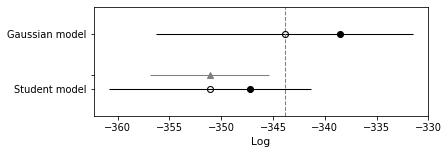

In [807]:
az.plot_compare(model_compare_WAIC)

# LOO Comparison

In [808]:
model_compare_LOO = az.compare(dataset_dict ={'Student model':fitStudent_id, 'Gaussian model':fit_id}, ic='loo')
model_compare_LOO

/home/agata/PycharmProjects/test1/venv/lib/python3.9/site-packages/arviz/stats/stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])
/home/agata/PycharmProjects/test1/venv/lib/python3.9/site-packages/arviz/stats/stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Gaussian model,0,-343.880162,5.389018,0.000000,0.826623,12.411448,0.000000,False,log
Student model,1,-351.223216,4.003779,7.343055,0.173377,9.834404,5.663364,False,log


According to results obtained from using LOO information criterion we can see that our second model has a rank 0 which means it's the best model. Higher IC for the second model indicates higher out-of-sample predictive fit ("better" model).

There are no warnings.

<AxesSubplot:xlabel='Log'>

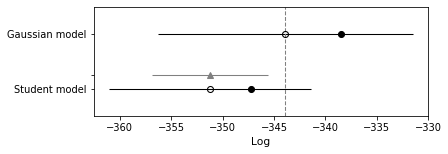

In [809]:
az.plot_compare(model_compare_LOO)

Both WAIC and PSIS-LOO information criterion indicate supremacy of our Gaussian model over the Student-T model.

Using Gaussian distribution and adding new parameter to our model (humidity) along with adjusting the prior (Beta from normal to lognormal) resulted in obtaining better results overall. Student-T distribution seemed like a good model to try based on nature of our dataset but ended up not performing as well as the second model.

Since our intention while adding new parameter was to improve our model, we expected the result of the comparison to be to the advantage of the second model. Obtained comparison results confirm our expectations.